In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [44]:
import time
import numpy as np
from functools import partial
from jfi import init
import matplotlib.pyplot as plt
jaxm = init(device="cpu")

import jaxopt

import pmpc
from pmpc import solve
from dubins_car_jax import f as f_fn, fx as fx_fn, fu as fu_fn, rollout, rollout2, rollout_fx
from dubins_car import f_np, fx_np, fu_np
from pmpc.remote import call
from pmpc.utils import TablePrinter


In [3]:
p = jaxm.array([1.0, 1.0, 0.3])
def f_fx_fu_fn(x, u):
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

M, N, xdim, udim = 1, 30, 4, 2
Q = jaxm.tile(jaxm.eye(xdim), (N, 1, 1))
R = jaxm.tile(1e-3 * jaxm.eye(udim), (N, 1, 1))
x0 = jaxm.tile(jaxm.ones(xdim), (1,))
X_ref, U_ref = jaxm.zeros((N, xdim)), jaxm.zeros((N, udim))
X_prev, U_prev = jaxm.ones((N, xdim)), jaxm.ones((N, udim))
u_l, u_u = -1 * jaxm.ones((N, udim)), 1 * jaxm.ones((N, udim))

In [4]:
f_fn(X_prev, U_prev, p)
fx = fx_fn(X_prev, U_prev, p)
fu = fu_fn(X_prev, U_prev, p)

In [5]:
fx2 = fx_np(np.array(X_prev), np.array(U_prev), np.array(p))
fu2 = fu_np(np.array(X_prev), np.array(U_prev), np.array(p))

In [ ]:
## Convex Cost

opts = dict(verbose=True, u_l=u_l, u_u=u_u)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

solver = "ecos"
opts["solver_settings"] = dict(solver=solver)
X, U, data = solve(*args, max_it=100, reg_x=1e1, reg_u=1e0, **opts)

In [10]:
f, fx, fu = f_fx_fu_fn(X_prev, U_prev)
py2jl = pmpc.julia_utils.py2jl
py2jl(x0, )
dims = dict(x0=1, f=1, fx=2, fu=2, X_prev=1, U_prev=1, Q=2, R=2, X_ref=1, U_ref=1)
args = [py2jl(np.array(z[None, ...]), dim) for (z, dim) in zip([x0, f, fx, fu, X_prev, U_prev, Q, R, X_ref, U_ref], dims.values())]
pmpc.scp_mpc.jl.lqp_generate_problem_matrices(*args);

In [11]:
f, fx, fu = f_fx_fu_fn(X_prev, U_prev)
args = x0, f, fx, fu, X_prev, U_prev, Q, R, X_ref, U_ref
ret = call("lqp_generate_problem_matrices", None, None, True, *args)

In [12]:
jaxm.norm(rollout_fx(x0, U, f, fx, fu, X_prev, U_prev) - rollout(x0, U, p), axis=-1)

Array([0.00000000e+00, 1.56730474e-11, 5.47640803e-02, 2.18695696e-01,
       4.33414479e-01, 5.90823485e-01, 6.86206401e-01, 7.36634264e-01,
       7.55816534e-01, 7.94692278e-01, 8.98342893e-01, 1.07601141e+00,
       1.31046798e+00, 1.57715146e+00, 1.85864971e+00, 2.14623851e+00,
       2.43606716e+00, 2.72649554e+00, 3.01690199e+00, 3.30712797e+00,
       3.59719139e+00, 3.88715093e+00, 4.17705624e+00, 4.46693844e+00,
       4.75681413e+00, 5.04669088e+00, 5.33657174e+00, 5.62646182e+00,
       5.91636190e+00, 6.20613566e+00, 6.49601480e+00], dtype=float64)

In [13]:
Ft_fn = jaxm.jit(lambda U: jaxm.jacobian(lambda U: rollout(x0, U, p)[1:, :])(U).reshape((N * xdim, N * udim)))
ft_fn = jaxm.jit(lambda U: rollout(x0, U, p)[1:, :].reshape((N * xdim,)))

In [14]:
P, q, A, b, G, l, u = [jaxm.array(z) for z in ret]

In [15]:
@jaxm.jit
def obj_fn(u, Ft, ft, P, q):
    x = Ft @ u + ft
    z = jaxm.cat([u, x])
    return 0.5 * jaxm.sum((P @ z) * z) + jaxm.sum(q * z)


Ft, ft = Ft_fn(U_prev), ft_fn(U_prev)
solver = jaxopt.BFGS(
    lambda U: obj_fn(U.reshape(-1), Ft, ft, P, q), maxiter=100, verbose=True, jit=True, tol=1e-9
)
#run = solver.run
run = jaxm.jit(solver.run)

In [16]:
make_matrices_shape = (
    jaxm.jax.ShapeDtypeStruct((180, 180,), jaxm.float64),
    jaxm.jax.ShapeDtypeStruct((180,), jaxm.float64),
    #jaxm.jax.ShapeDtypeStruct((120, 180,), jaxm.float64),
    #jaxm.jax.ShapeDtypeStruct((120,), jaxm.float64)
)

def make_matrices(x0, f, fx, fu, X_prev, U_prev, Q, R, X_ref, U_ref):
    args = x0, f, fx, fu, X_prev, U_prev, Q, R, X_ref, U_ref
    args = [np.array(x) for x in args]
    ret = call("lqp_generate_problem_matrices", None, None, True, *args)
    P, q, A, b = [jaxm.array(z) for z in ret[:4]]
    return P, q#, A, b

In [109]:
bmv = lambda A, x: (A @ x[..., None])[..., 0]


@jaxm.jit
def Ft_ft_fn(x0, U, f, fx, fu, X_prev, U_prev):
    N, xdim, udim = U.shape[-2], X_prev.shape[-1], U.shape[-1]

    ft_ = rollout_fx(x0, U, f, fx, fu, X_prev, U_prev)[..., 1:, :]
    Ft_ = jaxm.jacobian(lambda U: rollout_fx(x0, U, f, fx, fu, X_prev, U_prev)[..., 1:, :])(U)
    Ft, ft = Ft_, ft_

    #ft = rollout(x0, U, p)[..., 1:, :]
    #Ft = jaxm.jacobian(lambda U: rollout(x0, U, p)[..., 1:, :])(U)

    Ft, ft = Ft.reshape((N * xdim, N * udim)), ft.reshape((N * xdim,))
    return Ft, ft


@jaxm.jit
def obj_fn(U, Ft, ft, X_prev, U_prev, reg_x, reg_u, Q, R, X_ref, U_ref):
    X = (Ft @ (U - U_prev).reshape(U.shape[:-2] + (-1,)) + ft).reshape(U.shape[:-1] + (-1,))
    dX, dU = X - X_ref, U - U_ref
    J = 0.5 * jaxm.mean(jaxm.sum(dX * bmv(Q, dX), axis=-1))
    J = J + 0.5 * jaxm.mean(jaxm.sum(dU * bmv(R, dU), axis=-1))
    J = J + 0.5 * reg_x * jaxm.mean(jaxm.sum((X - X_prev) ** 2, -1))
    J = J + 0.5 * reg_u * jaxm.mean(jaxm.sum((U - U_prev) ** 2, -1))
    alpha = 1e1
    J = J + jaxm.mean(-jaxm.log(-alpha * (U - 1.0)) / alpha)
    J = J + jaxm.mean(-jaxm.log(-alpha * (-U - 1.0)) / alpha)
    return jaxm.where(jaxm.isfinite(J), J, 1e10)
    #return J


solver = jaxopt.BFGS(obj_fn, maxiter=300, verbose=False, tol=1e-3, jit=True)
run = jaxm.jit(solver.run)
update = jaxm.jit(solver.update)


@partial(jaxm.jit)
def run_with_state(z, *args, max_it: int = 10, state=None, **kw):
    if state is None:
        state = solver.init_state(z, *args, **kw)
    body_fn = lambda i, z_state: update(*z_state, *args, **kw)
    z_state = body_fn(0, (z, state))
    return jaxm.jax.lax.fori_loop(1, max_it, body_fn, z_state)

In [110]:
def opt_fn(f_fx_fu_fn, x0, X_prev, U_prev, Q, R, X_ref, U_ref, **kw):
    state = None
    t = time.time()
    tp = TablePrinter(
        ["it", "elaps", "obj", "resid", "reg_x", "reg_u", "sol_err"],
        ["%04d"] + 3 * ["%.3e"] + 3 * ["%.1e"],
    )
    tp.print_header()
    for it in range(kw.get("max_it", int(1e3))):
        f, fx, fu = f_fx_fu_fn(jaxm.cat([x0[..., None, :], X_prev[..., :-1, :]], -2), U_prev)
        Ft, ft = Ft_ft_fn(x0, U_prev, f, fx, fu, X_prev, U_prev)
        reg_x, reg_u = kw.get("reg_x", 1e0), kw.get("reg_u", 1e0)
        args = Ft, ft, X_prev, U_prev, reg_x, reg_u, Q, R, X_ref, U_ref
        U_prev_, state = run_with_state(U_prev, *args, state=state, max_it=50)
        # U_prev_, state = run(U_prev, *args)
        X_prev_ = bmv(Ft, (U_prev_ - U_prev).reshape((U_prev.shape[:-2] + (-1,)))) + ft
        X_prev_ = X_prev_.reshape(X_prev.shape)
        residx = jaxm.max(jaxm.norm(X_prev_ - X_prev, axis=-1))
        residu = jaxm.max(jaxm.norm(U_prev_ - U_prev, axis=-1))
        resid = jaxm.maximum(residx, residu)
        X_prev, U_prev = X_prev_, U_prev_
        obj = obj_fn(U_prev, *args)
        tp.print_values([it, time.time() - t, obj, resid, reg_x, reg_u, state.error])
    tp.print_footer()
    return X_prev, U_prev


In [111]:
U_prev = 1e-1 * np.ones((N, udim))
X, U = opt_fn(f_fx_fu_fn, x0, X_prev, U_prev, Q, R, X_ref, U_ref, max_it=100)

################################################################################
+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   | sol_err  |
+------+------------+------------+------------+----------+----------+----------+
| 0000 |  2.244e+00 |  1.571e+00 |  1.549e+00 |  1.0e+00 |  1.0e+00 |  1.2e-06 |
| 0001 |  3.751e+00 |  4.332e-01 |  7.833e-01 |  1.0e+00 |  1.0e+00 |  2.7e-06 |
| 0002 |  3.755e+00 |  2.346e-01 |  3.995e-01 |  1.0e+00 |  1.0e+00 |  4.0e-11 |
| 0003 |  3.759e+00 |  1.766e-01 |  2.310e-01 |  1.0e+00 |  1.0e+00 |  4.2e-09 |
| 0004 |  3.763e+00 |  1.600e-01 |  1.395e-01 |  1.0e+00 |  1.0e+00 |  2.7e-14 |
| 0005 |  3.768e+00 |  1.543e-01 |  9.047e-02 |  1.0e+00 |  1.0e+00 |  1.0e-12 |
| 0006 |  3.772e+00 |  1.520e-01 |  6.835e-02 |  1.0e+00 |  1.0e+00 |  8.6e-13 |
| 0007 |  3.776e+00 |  1.510e-01 |  5.791e-02 |  1.0e+00 |  1.0e+00 |  1.3e-08 |
| 0008 |  3.780e+00 |  1.504

In [ ]:
f, fx, fu = f_fx_fu_fn(X_prev, U_prev)
Ft, ft = Ft_ft_fn(x0, U_prev, f, fx, fu, X_prev, U_prev)
reg_x, reg_u = 3e0, 1e0
args = Ft, ft, X_prev, U_prev, reg_x, reg_u, Q, R, X_ref, U_ref
state = solver.init_state(U_prev, *args)
ret = update(U_prev, state, *args)

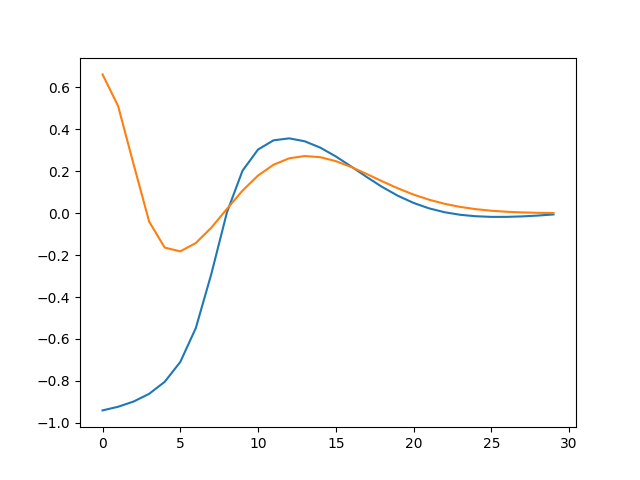

In [108]:
plt.figure()
plt.plot(U[:, 0])
plt.plot(U[:, 1])
plt.show()

In [106]:
fn = lambda x: jaxm.mean((x - jaxm.ones(x.shape)) ** 2)
solver = jaxopt.LBFGS(fn, maxiter=10000, verbose=True, jit=True)
run = jaxm.jit(solver.run)
solve = jaxm.jit(jaxm.jax.vmap(lambda x: solver.run(x).params))

In [ ]:
%time res = solve(jaxm.randn((1000, 10000,)))

CPU times: user 32.4 ms, sys: 47 µs, total: 32.5 ms
Wall time: 32.4 ms
